# fPCG_pipeline demo

Welcome to online demonstration of the fPCG_pipeline github repository. This package is for the analysis of fPCG data by statistics and machine learning.

# Installation

It can be installed with pip from github. All dependencies are included in requirements.txt, including hsmmlearn, or sickit-posthocs, so there is no need to manually install them.

In [1]:
pip install git+https://github.com/KristofBalint/fPCG_pipeline

  Cloning https://github.com/KristofBalint/fPCG_pipeline to /tmp/pip-req-build-s1v7c3qz
  Running command git clone --filter=blob:none --quiet https://github.com/KristofBalint/fPCG_pipeline /tmp/pip-req-build-s1v7c3qz
  Resolved https://github.com/KristofBalint/fPCG_pipeline to commit 1646f4d2b191f9a00a76cf723f65fdbcf09d9e53
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/jvkersch/hsmmlearn (to revision master) to /tmp/pip-install-jo7mta0y/hsmmlearn_37d195ed6a3043578aa5a4ae1de1101c
  Running command git clone --filter=blob:none --quiet https://github.com/jvkersch/hsmmlearn /tmp/pip-install-jo7mta0y/hsmmlearn_37d195ed6a3043578aa5a4ae1de1101c
  Resolved https://github.com/jvkersch/hsmmlearn to commit 69bc8aafb53033596e6a314d314547c6f2d197f2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import fPCG_pipeline
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pyPCG.io
import pyPCG.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

## Data download

First you need an fPCG dataset. In this demo we will use the Shiraz University fetal PCG database. If we are running this in google colab first we need to download the data.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/sufhsdb/1.0.1/

--2025-10-16 18:03:20--  https://physionet.org/files/sufhsdb/1.0.1/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/sufhsdb/1.0.1/index.html’

physionet.org/files     [ <=>                ]  47.14K  --.-KB/s    in 0.1s    

Last-modified header missing -- time-stamps turned off.
2025-10-16 18:03:20 (476 KB/s) - ‘physionet.org/files/sufhsdb/1.0.1/index.html’ saved [48275]

Loading robots.txt; please ignore errors.
--2025-10-16 18:03:20--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2025-10-16 18:03:20 (13.0 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2025-10-16 18

If you have downloaded the Shiraz university dataset to your computer beforehand, rewrite the path to the dataset.

In [ ]:
shiraz_path="physionet.org/files/sufhsdb/1.0.1/"

The Shiraz dataset has a RECORDS file with no extention containing all filenames where the fPCG data is stored. It also contains a spreadsheet for metadata.

In [ ]:
records=[]
with open(shiraz_path+"RECORDS","r") as file:
    file.readline()
    for line in file:
        records.append(line.replace('\n',''))
#print(records)

In [ ]:
maternal_data=pd.read_excel(shiraz_path+"FetalPCGSpreadsheet.xlsx")
maternal_data.dropna(how='all',inplace=True)
maternal_data

Subject ID Number of Gravid/Alive/Abortion  Maternal BMI  \
0       F93001                             NaN          28.5   
1       F93002                           2/0/1          29.7   
2       F93003                           1/0/0          32.9   
3       F93004                           1/0/0          27.7   
4       F93005                           1/0/0          21.5   
..         ...                             ...           ...   
127     F93108                           3/1/1          36.9   
128     F93109                           2/1/0          28.3   
129     F93110                           2/1/0          37.9   
130     F93111                           3/2/0          35.0   
131     F93112                           2/1/0          38.9   

     Pregnancy Term (weeks) Fetus gender (B: Boy, G: Girl)  \
0                      32.0                              B   
1                      40.0                              B   
2                      37.0                              B   
3                      38.0                              B   
4                      26.0                              B   
..                      ...                            ...   
127                    38.0                              B   
128                    39.0                              B   
129                    36.0                              B   
130                    40.0                              B   
131                    38.0                              B   

     Mother’s age (years)                      Clinical History  \
0                    20.0                                   NaN   
1                    23.0                                   NaN   
2                    38.0                                   NaN   
3                    23.0                                   NaN   
4                    22.0    Preterm rupture of membeans (PROM)   
..                    ...                                   ...   
127                  30.0                                   NaN   
128                  33.0  Mild mitral prolapse of mother heart   
129                  30.0                                   NaN   
130                  33.0                                   NaN   
131                  29.0                                   NaN   

    CTG Heart-rate (BPM). Each number corresponds to the average fetal heart-rate over 10 seconds of the signal, whenever available. Brackets denote unreported values  \
0                                      132-148-150-150                                                                                                                   
1                              150-147-152-150-148-150                                                                                                                   
2                                   []-142-130-135-136                                                                                                                   
3                       []-152-144-142-143-138-135-131                                                                                                                   
4                              150-156-156-154-158-155                                                                                                                   
..                                                 ...                                                                                                                   
127                                                NaN                                                                                                                   
128                                                NaN                                                                                                                   
129                                                NaN                                                                                                     

In [ ]:
maternal_data.describe()

Maternal BMI  Pregnancy Term (weeks)  Mother’s age (years)     
count    112.000000              112.000000            112.000000  0.0
mean      29.209821               36.455357             29.250000  NaN
std        3.970975                3.374222              5.845611  NaN
min       19.500000               26.000000             16.000000  NaN
25%       26.275000               35.000000             25.000000  NaN
50%       28.650000               38.000000             29.000000  NaN
75%       31.600000               39.000000             33.000000  NaN
max       38.900000               41.000000             47.000000  NaN

# Preprocessing

The preprocessing steps include segmenting the data overlapping parts, segmenting to S1 and S2 sounds, filtering, and pairing the sound data with the metadata.

In the case of the Shiraz database, the data needs to be downsampled, as it has an unnecessarily high sample rate. Also includes categorising the metadata into discrete categories.

The pair_sound_data() function pairs the metadata with the sound data. It goes through all records, downsamples the audio, pairs it with the metadata, segments the audio, and outputs a list containing the original and the segmented audio paired with the metadata.

In [ ]:
sound_with_data=fPCG_pipeline.pair_sound_data(records,shiraz_path,maternal_data)

Pregnancy Term for f101: 39.0
Pregnancy Term for f102-1: 37.0
Pregnancy Term for f102: 37.0
Pregnancy Term for f103-1: 26.0
Pregnancy Term for f103: 26.0
Pregnancy Term for f104: 39.0
Pregnancy Term for f105-1: 37.0
Pregnancy Term for f105: 37.0
Pregnancy Term for f106: 39.0
Pregnancy Term for f107: 39.0
Pregnancy Term for f108: 38.0
Pregnancy Term for f109: 39.0
Pregnancy Term for f10: 41.0
Pregnancy Term for f110: 36.0
Pregnancy Term for f111: 40.0
Pregnancy Term for f112: 38.0
Pregnancy Term for f11: 35.0
Pregnancy Term for f12: 37.0
Pregnancy Term for f13: 39.0
Pregnancy Term for f14: 38.0
Pregnancy Term for f15: 40.0
Pregnancy Term for f16: 35.0
Pregnancy Term for f17-1: 29.0
Pregnancy Term for f17-2: 29.0
Pregnancy Term for f18: 29.0
Pregnancy Term for f19: 34.0
Pregnancy Term for f1: 32.0
Pregnancy Term for f20: 37.0
Pregnancy Term for f21: 36.0
Pregnancy Term for f22: 34.0
Pregnancy Term for f23-1: 37.0
Pregnancy Term for f23-2: 37.0
Pregnancy Term for f24: 38.0
Pregnancy Term 

From statistical plotting you can make plots to visualise the raw sound data and the downsampled sound data.
Here is an example of a part of the sound data's spectrogram and raw signal.

In [ ]:


sound_file=shiraz_path+records[39]+".wav"
data,fs=pyPCG.io.read_signal_file(sound_file,"wav")

start_time = 20
end_time = 30

start_sample = int(start_time * fs)
end_sample = int(end_time * fs)


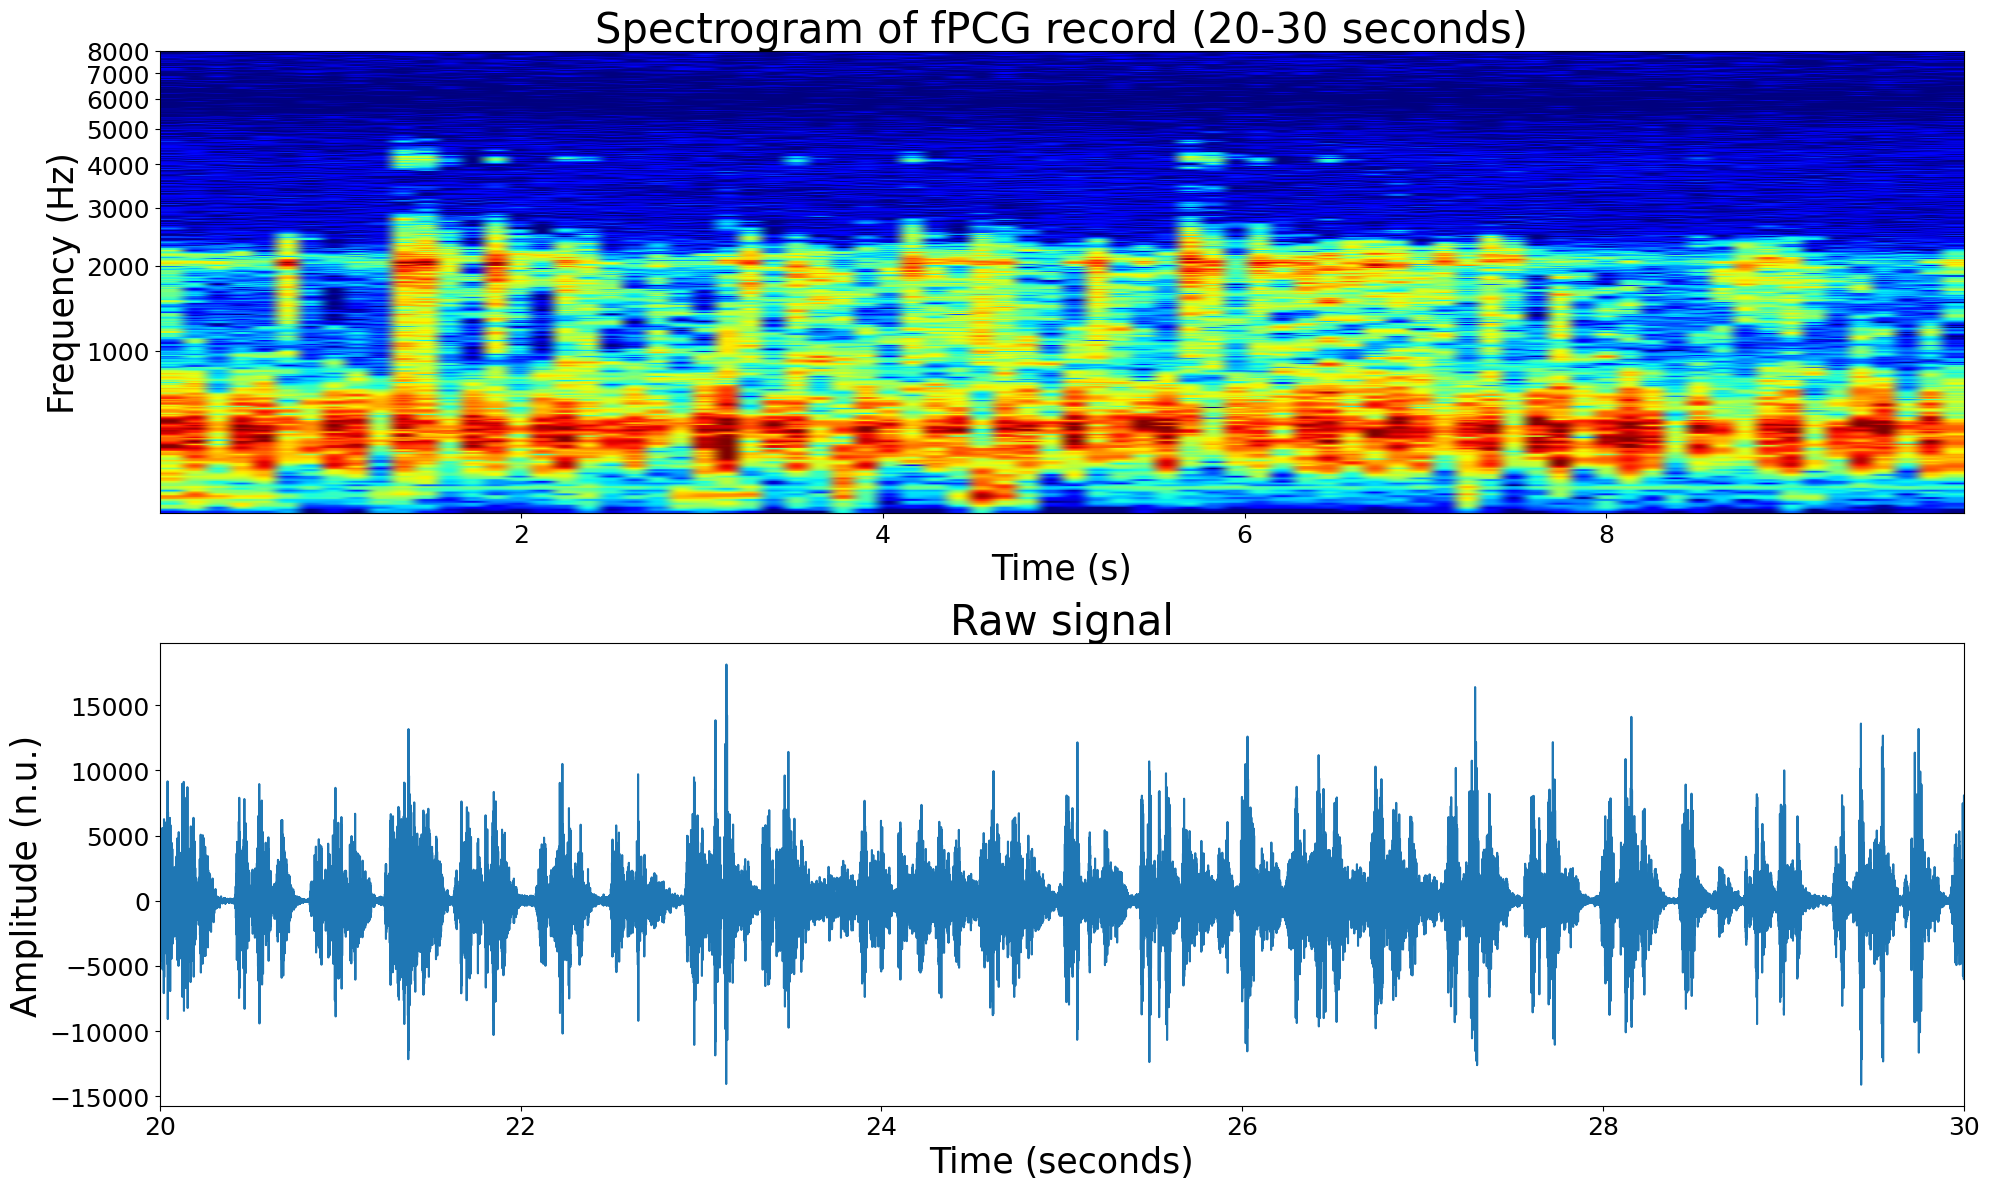

In [ ]:
fPCG_pipeline.spectrogram_and_raw_signal(data,start_time,end_time,fs)

Here is the example of frequency spectrum for the downsampled data by itself and filtered.

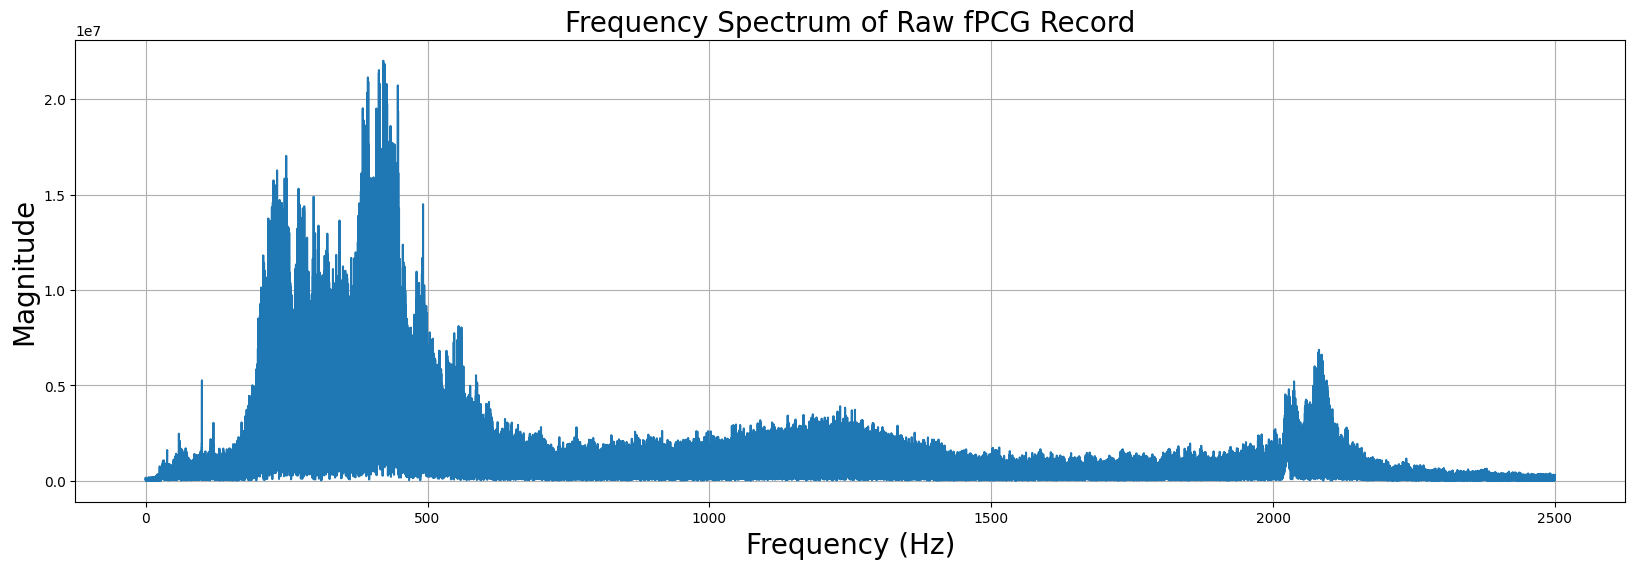

In [ ]:
raw_fpcg_sound=sound_with_data[0][0]
fPCG_pipeline.plot_freq_spectrogram(raw_fpcg_sound)

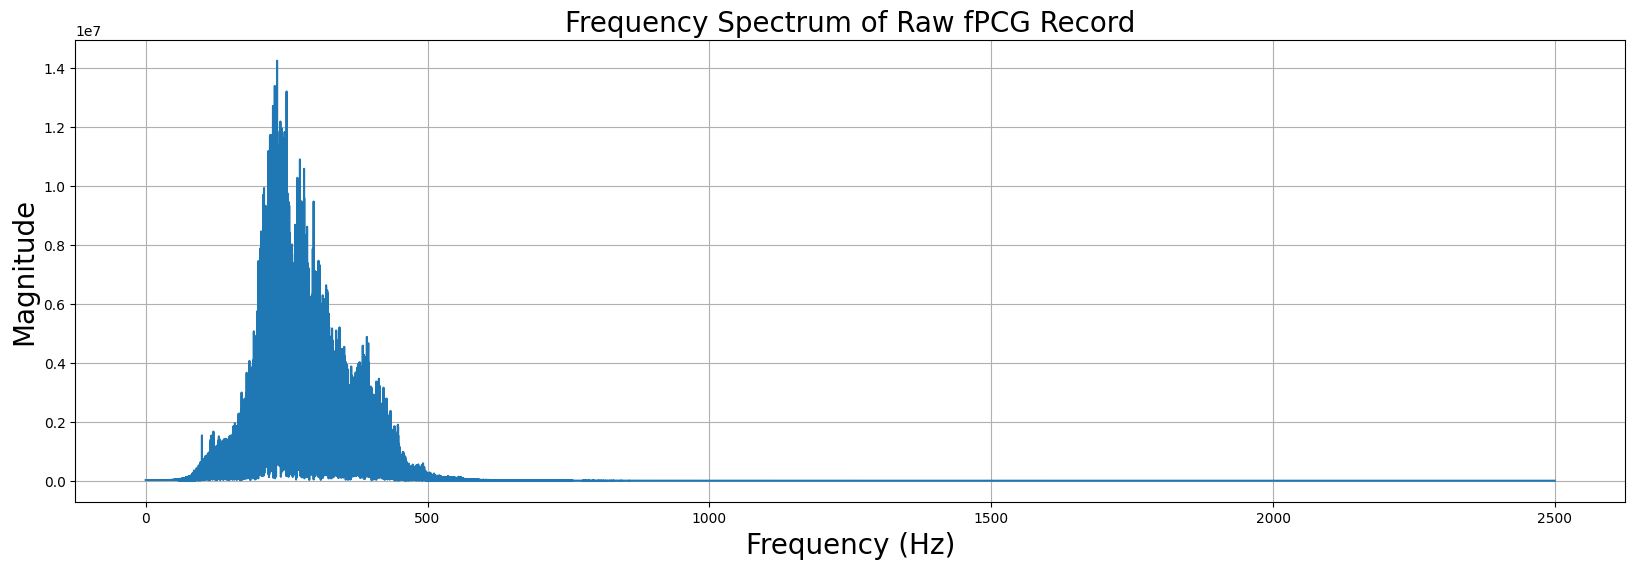

In [ ]:
fPCG_pipeline.plot_freq_spectrogram(raw_fpcg_sound,filtered=True)

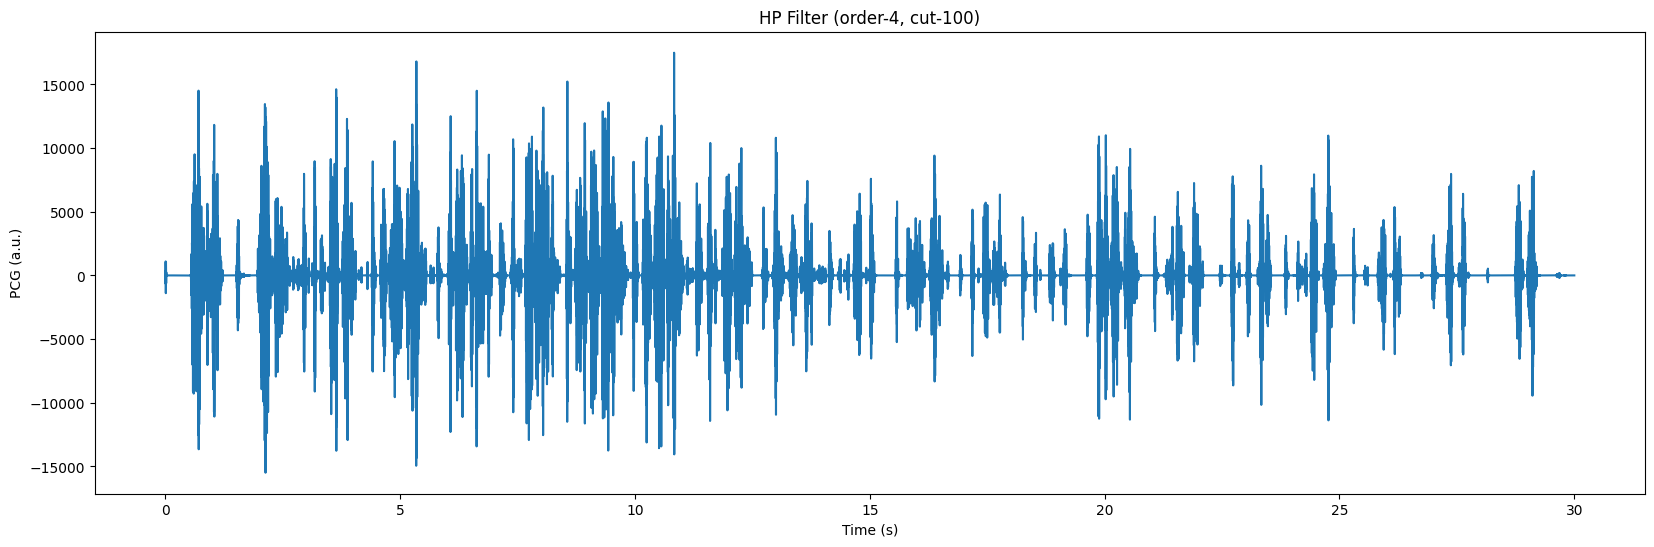

In [ ]:
f101=sound_with_data[64][0]
#pyPCG.plot(f101)
denoised=pyPCG.preprocessing.wt_denoise_sth(f101)
#pyPCG.plot(denoised)
filtered=pyPCG.preprocessing.filter(denoised,filt_ord=4,filt_cutfreq=350,filt_type='LP')
filtered=pyPCG.preprocessing.filter(filtered,filt_ord=4,filt_cutfreq=100,filt_type='HP')
plt.figure(figsize=(20,6))
pyPCG.plot(filtered)

# Feature extraction

The data processing module contains feature extraction and metadata processing.

The process function is responsible for feature extraction. It takes in the sound with data preprocessed list, calculates features available in the pyPCG package, and outputs a dataframe. The optional parameter categorize puts the metadata into discrete categories (default False), and the optional parameter save determines to save the data into a .csv file (default True)

In [ ]:
fPCG_pipeline.process(sound_with_data=sound_with_data)

Time delta: 0.0001664020001044264
Zero cross rate: 0.4527211599997827
Ramp time: 0.09318616900009147
Peak spread: 0.6396042790001957
Peak width: 0.33986330099969564
Peak centroid: 0.40987931200015737
Max freq: 0.8133762669999669
Spectral spread: 1.4526520379999965
Spectral width: 0.9340651669999716
Spectral centroid: 1.0870452500003012


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


DWT intensity: 0.23089192399993408
DWT entropy: 0.1950508519998948


/usr/local/lib/python3.12/dist-packages/pyPCG/features.py:438: RuntimeWarning: invalid value encountered in scalar divide
  D = np.log10(L/a)/np.log10(d/a)


Katz fd: 1.841790189999756
f101
Time delta: 0.00010517999999137828
Zero cross rate: 0.06527432399980171
Ramp time: 0.016719718999866018
Peak spread: 0.09658903700028532
Peak width: 0.051429912999992666
Peak centroid: 0.06435307199990348
Max freq: 0.21868359700010842
Spectral spread: 0.3720497819999764
Spectral width: 0.23840460999963398
Spectral centroid: 0.27720235300012064
DWT intensity: 0.05805458399981944
DWT entropy: 0.05356954099988798
Katz fd: 0.44426283700022395
f101
Time delta: 6.478400018750108e-05
Zero cross rate: 0.07092311599990353
Ramp time: 0.019083663999936107
Peak spread: 0.09934950500019113
Peak width: 0.05223795699976108
Peak centroid: 0.06264137500011202
Max freq: 0.2183476109998992
Spectral spread: 0.37729287599995587
Spectral width: 0.24084110700005112
Spectral centroid: 0.4186668190000091
DWT intensity: 0.0997603710002295
DWT entropy: 0.08759418999989066
Katz fd: 0.6407517279999411
f101
Time delta: 7.520500003010966e-05
Zero cross rate: 0.11427248399968448
Ramp t

/usr/local/lib/python3.12/dist-packages/pyPCG/features.py:408: RuntimeWarning: divide by zero encountered in log2
  ent = -np.sum(win**2*np.log2(win**2))
/usr/local/lib/python3.12/dist-packages/pyPCG/features.py:408: RuntimeWarning: invalid value encountered in multiply
  ent = -np.sum(win**2*np.log2(win**2))


A streamkimeneten csak az utolsó 5000 sor látható.
Katz fd: 0.6116141759994207
f93
Time delta: 7.065599857014604e-05
Zero cross rate: 0.06660277600167319
Ramp time: 0.02000322199819493
Peak spread: 0.09653466000236222
Peak width: 0.04900533999898471
Peak centroid: 0.06255516899909708
Max freq: 0.21035447800022666
Spectral spread: 0.5429886450001504
Spectral width: 0.3656259380004485
Spectral centroid: 0.4190646709976136
DWT intensity: 0.0879539540001133
DWT entropy: 0.07832677500118734
Katz fd: 0.6487376989971381
f93
Time delta: 7.875099981902167e-05
Zero cross rate: 0.12140924599952996
Ramp time: 0.025145060000795638
Peak spread: 0.1720598930005508
Peak width: 0.0858992749999743
Peak centroid: 0.10123759999987669
Max freq: 0.20902360299805878
Spectral spread: 0.36379976000171155
Spectral width: 0.2314304120009183
Spectral centroid: 0.2641288659979182
DWT intensity: 0.05975450100231683
DWT entropy: 0.05113907899794867
Katz fd: 0.44223104100092314
f93
Time delta: 0.0001304239995079115
Z

# Metadata processing

The other part of the data processing module is metadata processing. It is responsible for reading in the features from the .csv file saved by the process function, and removes cleans up the metadata. It does so by one-hot encoding the clinical history, and removes redundancy from it such as writing the same condition in different ways.

In [3]:
features_df=fPCG_pipeline.read_data("processed.csv","Shiraz")

Due to the overlapping semgents, the dataset is very redundant, and it disturbs the statistical plotting. There will be no visible differences in the distribution of variables, so we need to remove the overlap for it. Remove overlap selects every nth row of the dataset, n is the ratio of the segmentation segment size/segment offset.

In [4]:
no_overlap=fPCG_pipeline.remove_overlap(features_df,6)
no_overlap


Pregnancy term category  BMI category  Age category Baby gender  \
0                       39.0          35.3          41.0           B   
1                       39.0          35.3          41.0           B   
2                       39.0          35.3          41.0           B   
3                       39.0          35.3          41.0           B   
4                       39.0          35.3          41.0           B   
..                       ...           ...           ...         ...   
965                     39.0          25.8          28.0           G   
966                     39.0          25.8          28.0           G   
967                     39.0          25.8          28.0           G   
968                     39.0          25.8          28.0           G   
969                     39.0          25.8          28.0           G   

     Time delta  Zero cross rate  Ramp time  Peak spread  Peak width  \
0      0.001248         0.114816   0.000531     0.982474    1.101954   
1      0.001567         0.124623   0.000730     1.228864    1.362329   
2      0.001545         0.109414   0.000656     1.220359    1.369590   
3      0.001673         0.107305   0.000742     1.307213    1.454412   
4      0.001544         0.110350   0.000656     1.224072    1.380463   
..          ...              ...        ...          ...         ...   
965    0.001422         0.127744   0.000667     1.130225    1.223856   
966    0.001585         0.126663   0.000725     1.248454    1.329199   
967    0.001584         0.125909   0.000724     1.252703    1.371202   
968    0.001541         0.126890   0.000651     1.217657    1.317321   
969    0.001400         0.130280   0.000636     1.118981    1.223022   

     Peak centroid  ...  \
0         2.637841  ...   
1         3.442025  ...   
2         3.359795  ...   
3         3.661064  ...   
4         3.348874  ...   
..             ...  ...   
965       3.105751  ...   
966       3.500000  ...   
967       3.497438  ...   
968       3.344176  ...   
969       3.037564  ...   

     Due to previous abortions she is admitted to be monitored  \
0                                                False           
1                                                False           
2                                                False           
3                                                False           
4                                                False           
..                                                 ...           
965                                              False           
966                                              False           
967                                              False           
968                                              False           
969                                              False           

     High fetal heart rate  Hypothyroidism  \
0                    False               0   
1                    False               0   
2                    False               0   
3                    False               0   
4                    False               0   
..                     ...             ...   
965                  False               0   
966                  False               0   
967                  False               0   
968                  False               0   
969                  False               0   

     Mild mitral prolapse of mother heart   PROM  Preeclampsia  \
0                                   False  False         False   
1                                   False  False         False   
2                                   False  False         False   
3                                   False  False         False   
4                                   False  False         False   
..                                    ...    ...           ...   
965                                 False  False         False   
966                                 False  False         False   
967       

Apply category applies discretization to metadata, such as pregnancy term, BMI and age.

In [5]:
no_overlap=fPCG_pipeline.apply_category(no_overlap)
no_overlap

Pregnancy term category BMI category Age category Baby gender  Time delta  \
0                     38-39          31<          33<           B    0.001248   
1                     38-39          31<          33<           B    0.001567   
2                     38-39          31<          33<           B    0.001545   
3                     38-39          31<          33<           B    0.001673   
4                     38-39          31<          33<           B    0.001544   
..                      ...          ...          ...         ...         ...   
965                   38-39          26>        25-29           G    0.001422   
966                   38-39          26>        25-29           G    0.001585   
967                   38-39          26>        25-29           G    0.001584   
968                   38-39          26>        25-29           G    0.001541   
969                   38-39          26>        25-29           G    0.001400   

     Zero cross rate  Ramp time  Peak spread  Peak width  Peak centroid  ...  \
0           0.114816   0.000531     0.982474    1.101954       2.637841  ...   
1           0.124623   0.000730     1.228864    1.362329       3.442025  ...   
2           0.109414   0.000656     1.220359    1.369590       3.359795  ...   
3           0.107305   0.000742     1.307213    1.454412       3.661064  ...   
4           0.110350   0.000656     1.224072    1.380463       3.348874  ...   
..               ...        ...          ...         ...            ...  ...   
965         0.127744   0.000667     1.130225    1.223856       3.105751  ...   
966         0.126663   0.000725     1.248454    1.329199       3.500000  ...   
967         0.125909   0.000724     1.252703    1.371202       3.497438  ...   
968         0.126890   0.000651     1.217657    1.317321       3.344176  ...   
969         0.130280   0.000636     1.118981    1.223022       3.037564  ...   

     Due to previous abortions she is admitted to be monitored  \
0                                                False           
1                                                False           
2                                                False           
3                                                False           
4                                                False           
..                                                 ...           
965                                              False           
966                                              False           
967                                              False           
968                                              False           
969                                              False           

     High fetal heart rate  Hypothyroidism  \
0                    False               0   
1                    False               0   
2                    False               0   
3                    False               0   
4                    False               0   
..                     ...             ...   
965                  False               0   
966                  False               0   
967                  False               0   
968                  False               0   
969                  False               0   

     Mild mitral prolapse of mother heart   PROM  Preeclampsia  \
0                                   False  False         False   
1                                   False  False         False   
2                                   False  False         False   
3                                   False  False         False   
4                                   False  False         False   
..                                    ...    ...           ...   
965                                 False  False         False   
966                                 False  False         False   
967                                 False  False         False   
968                                 False  False         False  

# Statistical analysis

The statistical plotting module has multiple plots with statistical tests to determine the differences of the distribution of the features.

Kruskal-Wallis H test for Time delta rate: H = 11.87, p-value = 0.001
         1        2
1  1.00000  0.00057
2  0.00057  1.00000
Kruskal-Wallis H test for Zero cross rate rate: H = 18.13, p-value = 0.000
          1         2
1  1.000000  0.000021
2  0.000021  1.000000


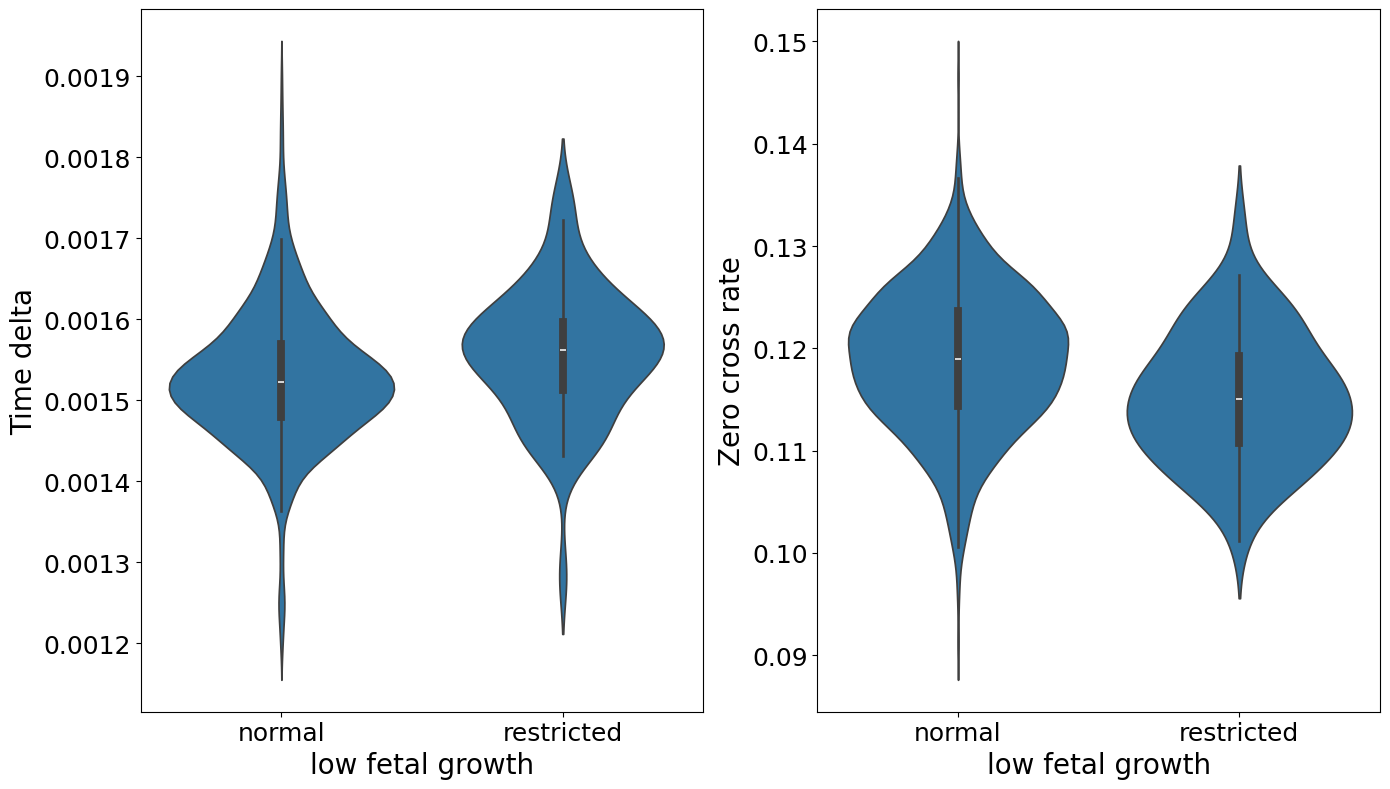

Kruskal-Wallis H test for Peak width rate: H = 6.11, p-value = 0.013
         1        2
1  1.00000  0.01343
2  0.01343  1.00000
Kruskal-Wallis H test for Peak spread rate: H = 8.72, p-value = 0.003
          1         2
1  1.000000  0.003145
2  0.003145  1.000000


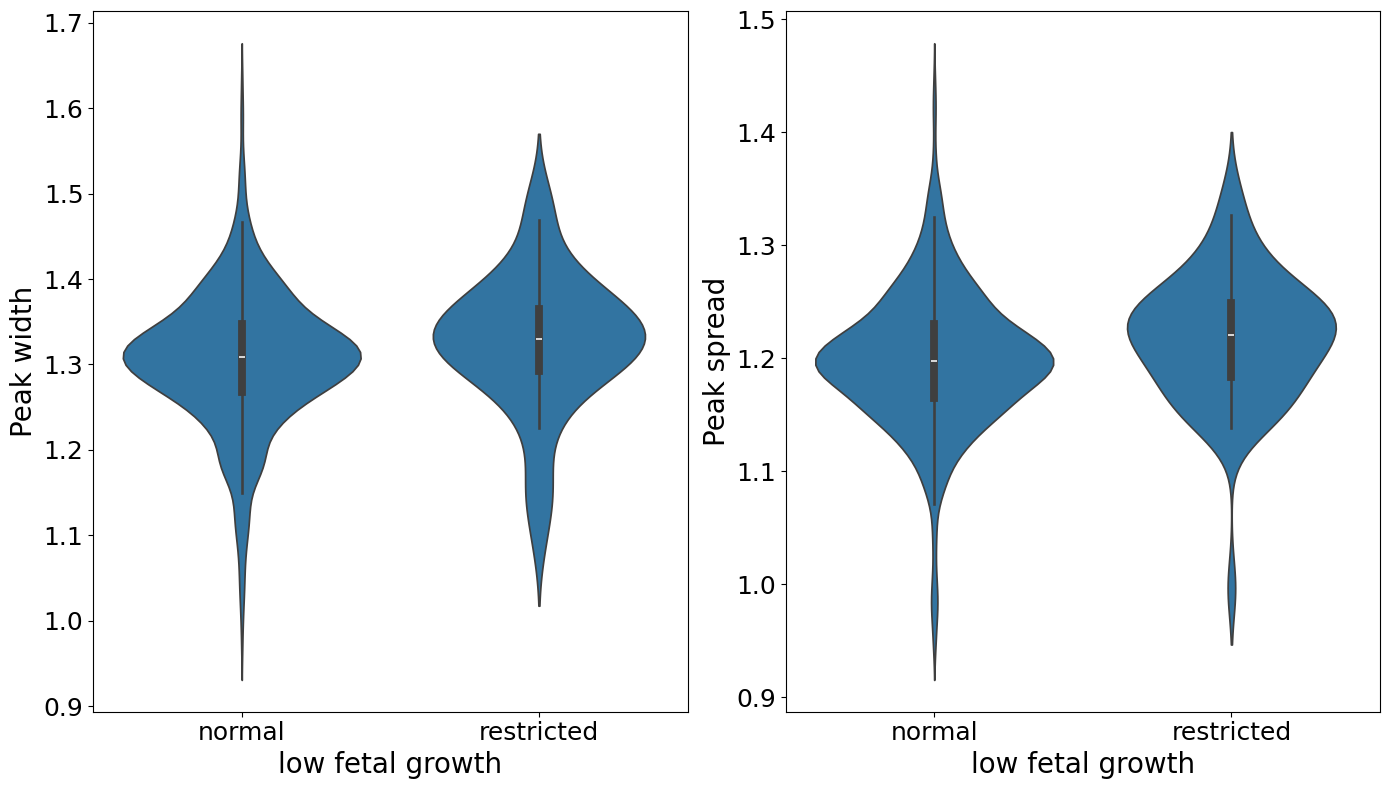

Kruskal-Wallis H test for Ramp time rate: H = 5.25, p-value = 0.022
          1         2
1  1.000000  0.021944
2  0.021944  1.000000
Kruskal-Wallis H test for Peak centroid rate: H = 10.71, p-value = 0.001
          1         2
1  1.000000  0.001067
2  0.001067  1.000000


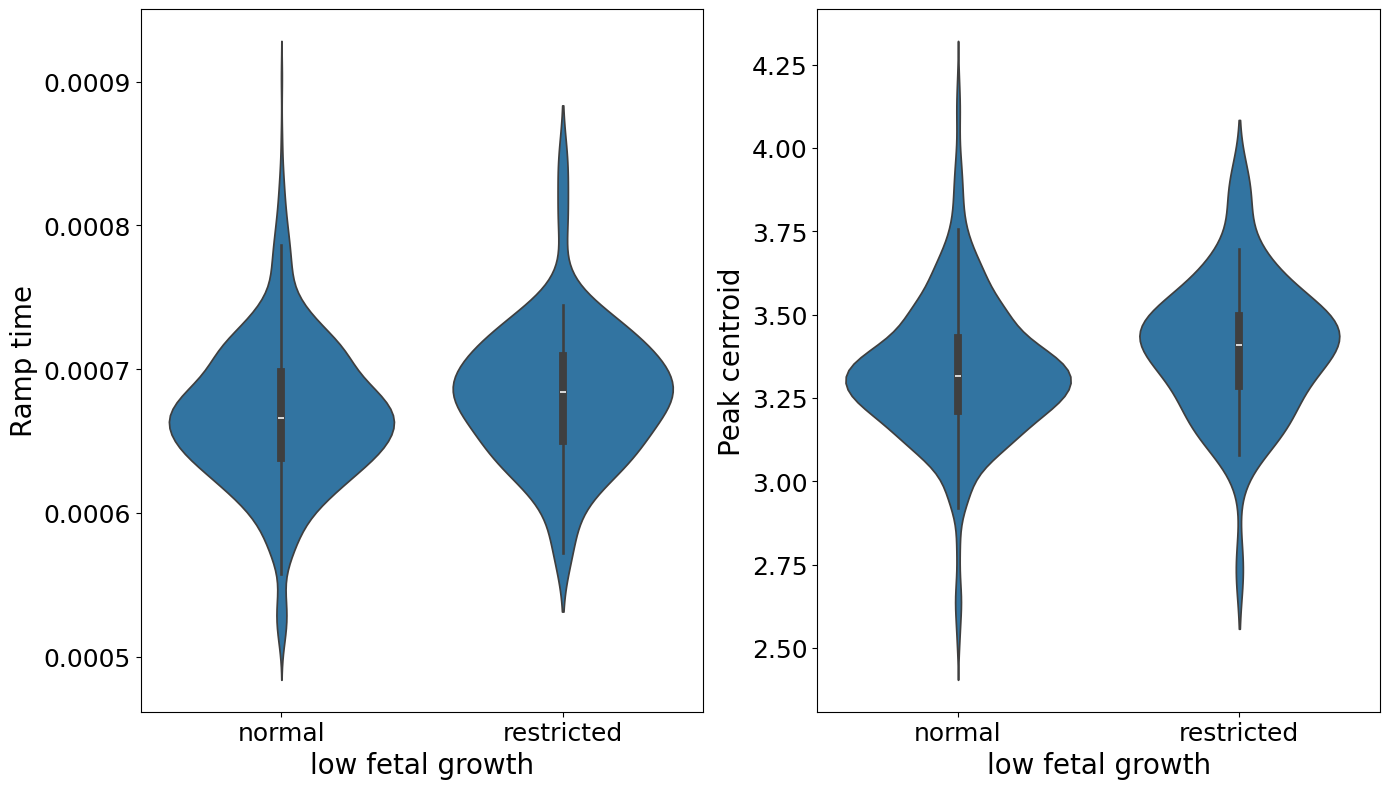

Kruskal-Wallis H test for Max frequency rate: H = 8.23, p-value = 0.004
          1         2
1  1.000000  0.004115
2  0.004115  1.000000
Kruskal-Wallis H test for Spectral spread rate: H = 17.57, p-value = 0.000
          1         2
1  1.000000  0.000028
2  0.000028  1.000000


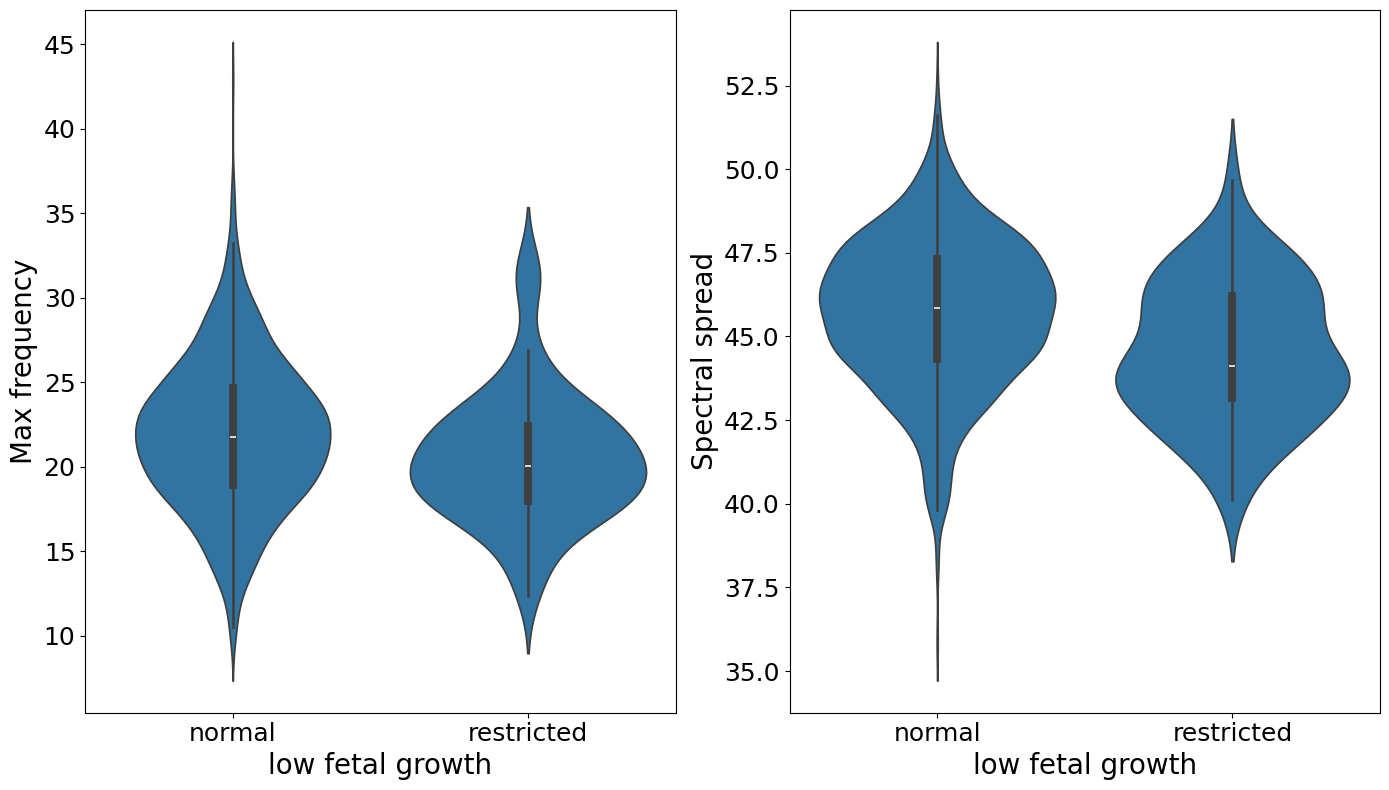

Kruskal-Wallis H test for Spectral width rate: H = 14.36, p-value = 0.000
          1         2
1  1.000000  0.000151
2  0.000151  1.000000
Kruskal-Wallis H test for Spectral centroid rate: H = 17.87, p-value = 0.000
          1         2
1  1.000000  0.000024
2  0.000024  1.000000


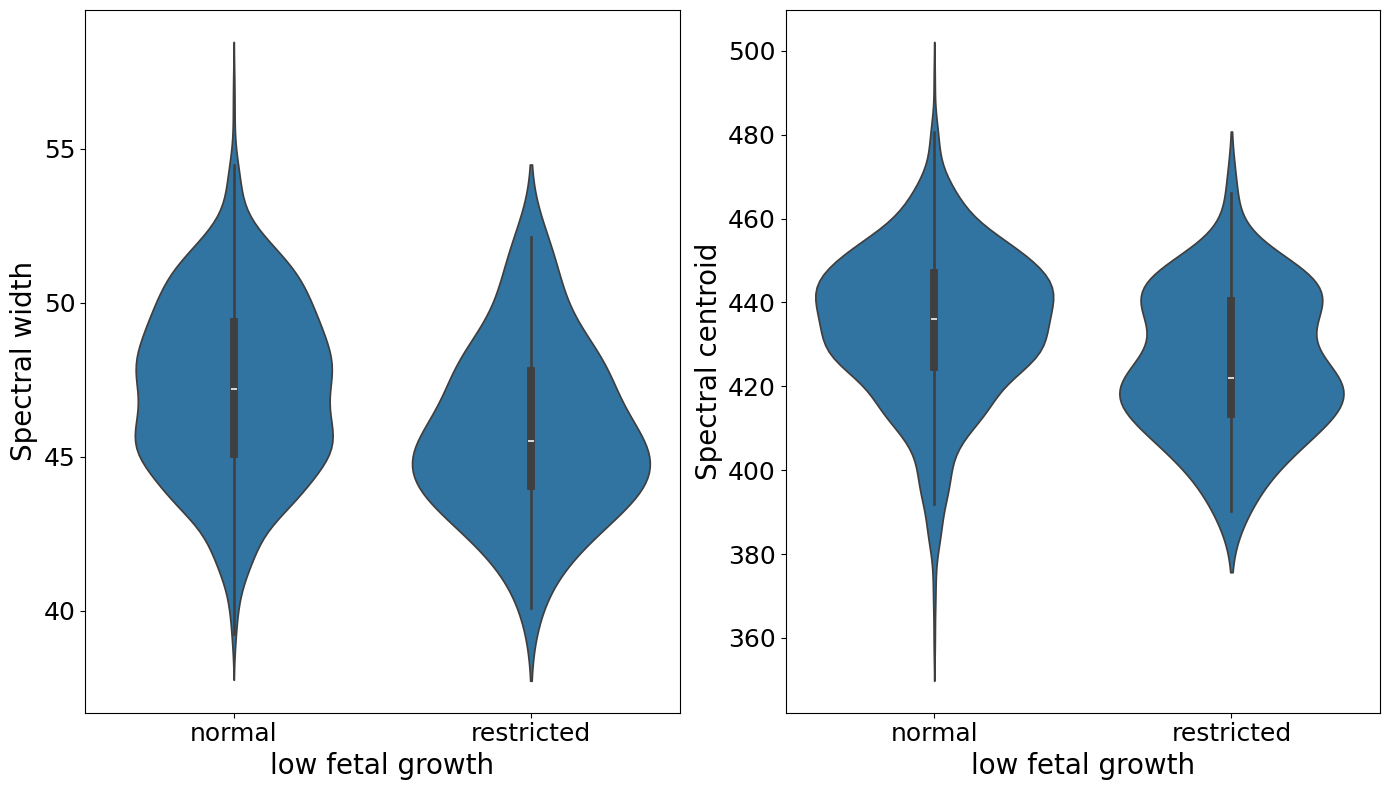

Kruskal-Wallis H test for Minimum rate: H = 32.62, p-value = 0.000
              1             2
1  1.000000e+00  1.121614e-08
2  1.121614e-08  1.000000e+00
Kruskal-Wallis H test for Maximum rate: H = 29.81, p-value = 0.000
              1             2
1  1.000000e+00  4.759350e-08
2  4.759350e-08  1.000000e+00


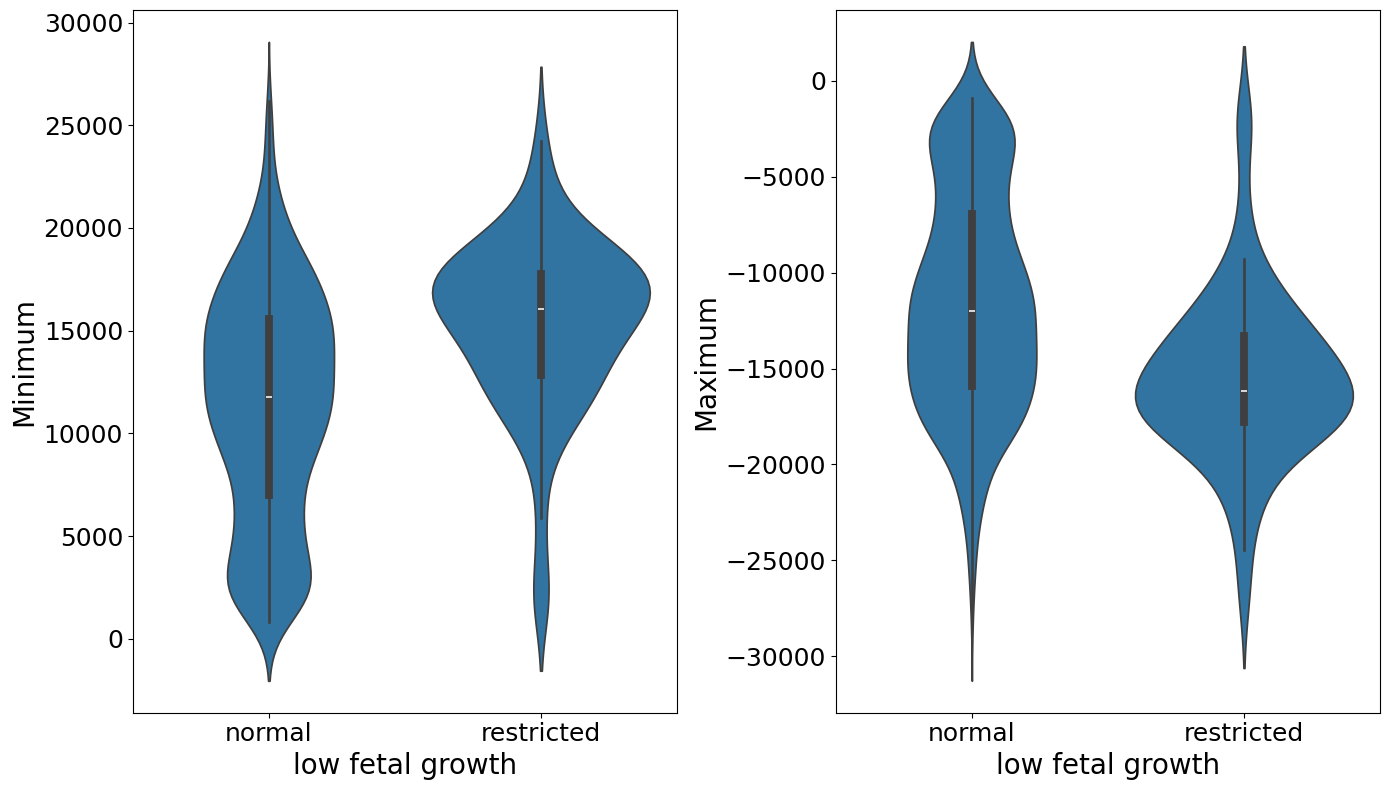

Kruskal-Wallis H test for DWT entropy rate: H = 7.60, p-value = 0.006
          1         2
1  1.000000  0.005822
2  0.005822  1.000000
Kruskal-Wallis H test for STD rate: H = 16.62, p-value = 0.000
          1         2
1  1.000000  0.000046
2  0.000046  1.000000


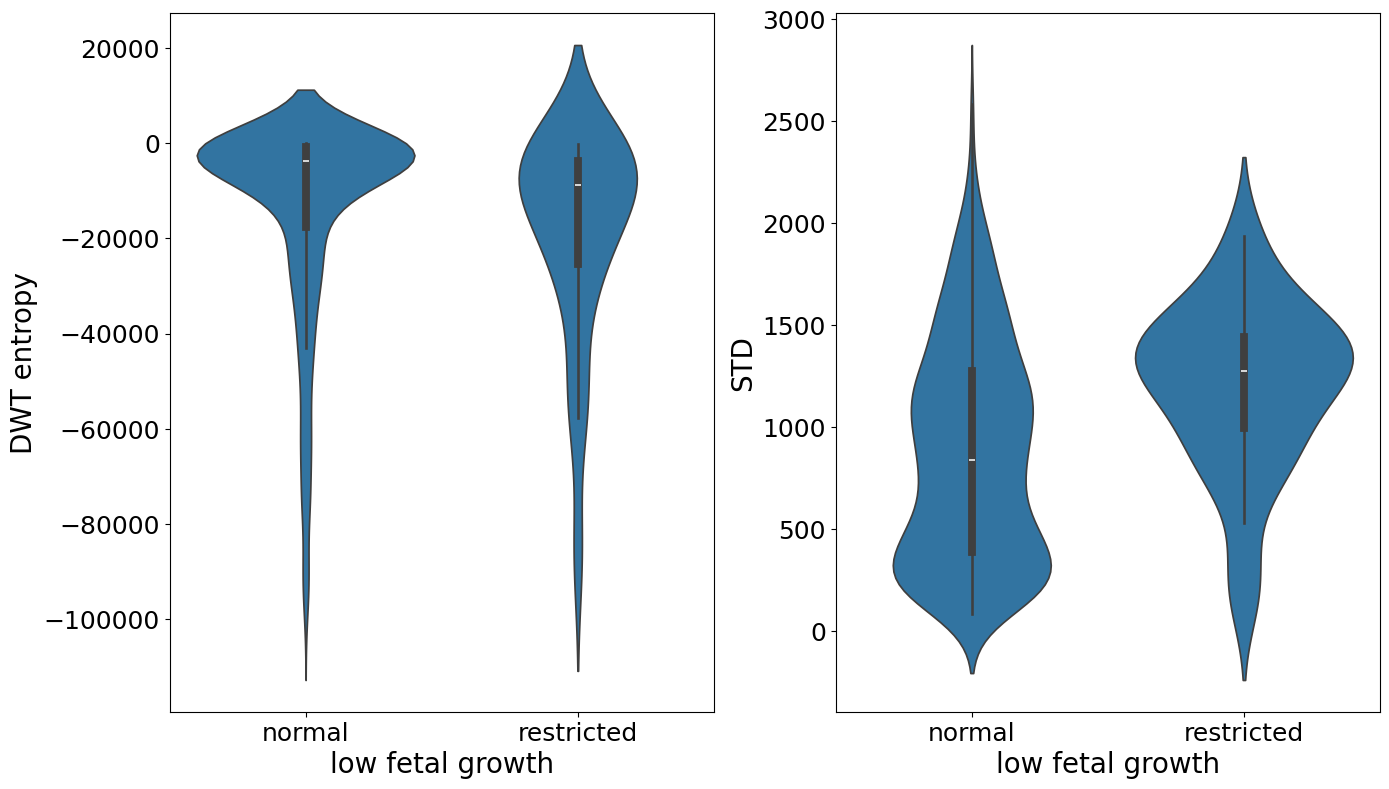

Kruskal-Wallis H test for Median rate: H = 1.63, p-value = 0.202
          1         2
1  1.000000  0.201735
2  0.201735  1.000000
Kruskal-Wallis H test for Mean rate: H = 1.69, p-value = 0.194
          1         2
1  1.000000  0.193989
2  0.193989  1.000000


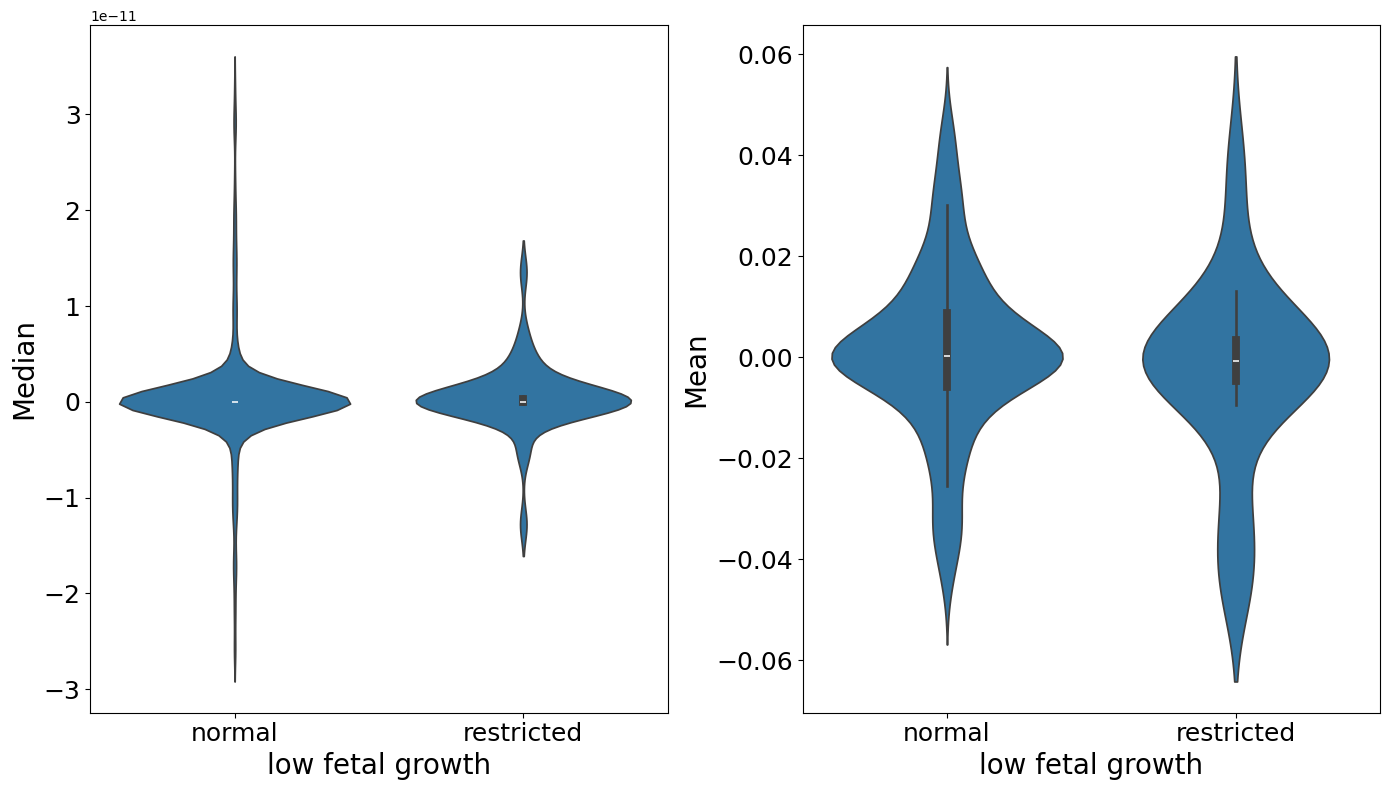

In [9]:
comparable="low fetal growth"
features=[["Time delta","Zero cross rate"],["Peak width","Peak spread"],["Ramp time","Peak centroid"],
          ["Max frequency", "Spectral spread"],["Spectral width","Spectral centroid"],["Minimum","Maximum"]]
trim_features=[["DWT entropy","STD"],["Median", "Mean"]]
x_re=[[0, 1], ['normal', 'restricted']]
for i in range(len(features)):
  fPCG_pipeline.plot_viol(no_overlap,comparable,features[i],x_re,lbl_fsize=20,tck_fsize=18)
  plt.tight_layout()
  plt.show()
for i in range(len(trim_features)):
  fPCG_pipeline.plot_viol(no_overlap,comparable,trim_features[i],x_re,lbl_fsize=20,tck_fsize=18,trim=True)
  plt.tight_layout()
  plt.show()

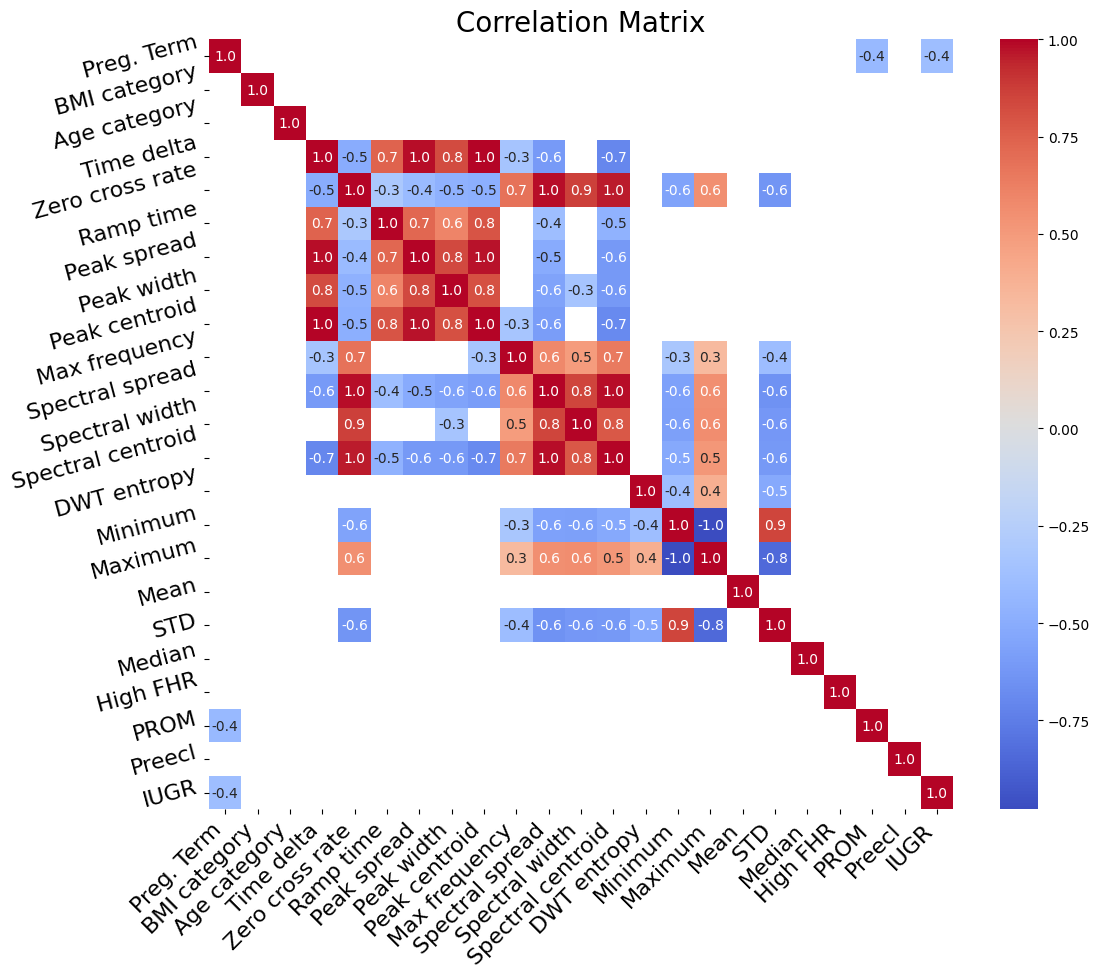

In [ ]:
#import matplotlib.pyplot as plt
#import seaborn as sns

features_to_drop=['Baby gender','Admitted because of the abnormality in fetus NST'
,'Admitted because of the sever change in fetal heart rate'
,'Admitted in psychology ward but still not definite diagnosis'
,'Due to previous abortions she is admitted to be monitored'
,'Mild mitral prolapse of mother heart'
,'The first gravidity was twins, one of them died after birth the other born while it was CP.'
,"Decrease of amniotic fluid"
,"Hypothyroidism"
,"Severe hypoglycemia"
,"Epilepsy"
,"DWT intensity"
,"Katz fraction dimension"
]
column_renames = {
        'Pregnancy term category': 'Preg. Term',
        'High fetal heart rate': 'High FHR',
        'Preeclampsia': 'Preecl',
        'low fetal growth': 'IUGR'
    }

fPCG_pipeline.plot_correlation_matrix(features_df,column_renames=column_renames,feats_to_drop=features_to_drop)

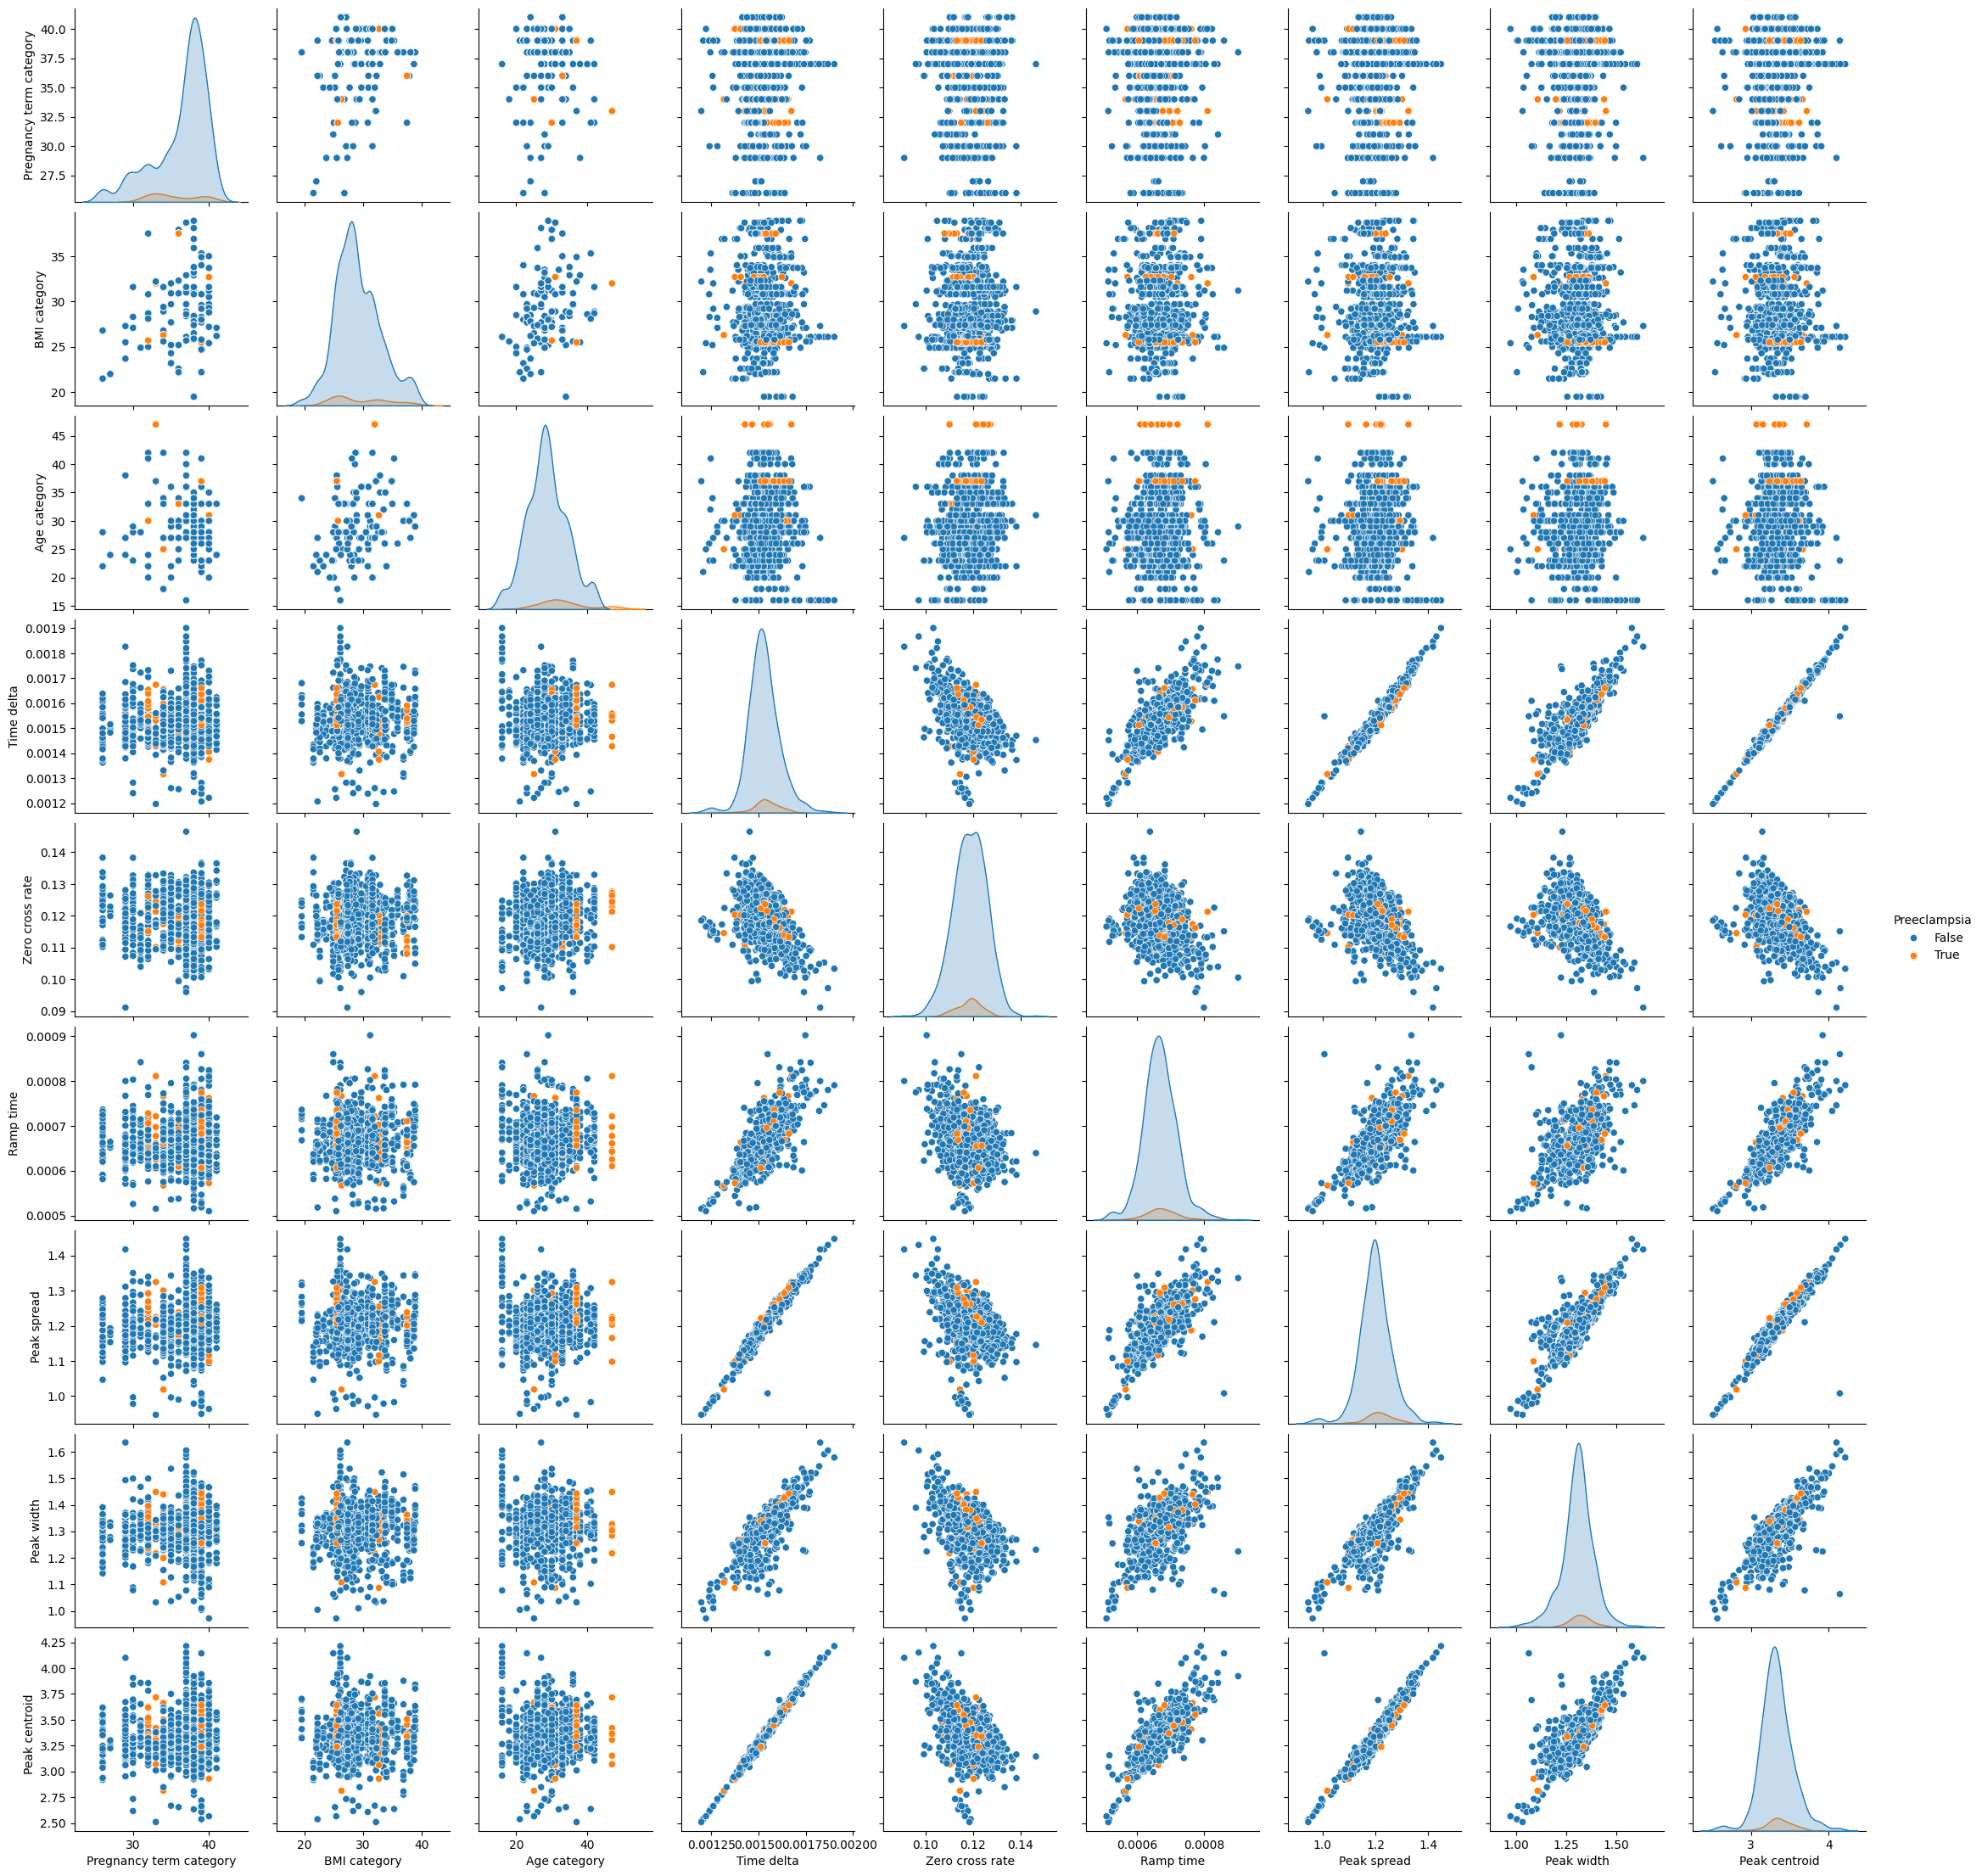

In [ ]:
features=["Pregnancy term category","BMI category", "Age category","Time delta","Zero cross rate", "Ramp time", "Peak spread", "Peak width", "Peak centroid","Preeclampsia"]
fPCG_pipeline.pairplot(no_overlap,features,"Preeclampsia")

# Machine learning

The machine learning part analyses the fPCG data with Machine learning. It looks at multiple predictors and determines how well they fit by multiple metrics.

This part is built modularly. It requires a tasks dictionary of dictionaries, and a models dictionary. Ever task contains a required target element, which is what the model will fit to. The use smote boolean determines if the fitting will use synthetic over sampling on the dataset or not. Transform will use a transformation on one the dataset, in this example it discretizes the category for pregnancy term. Dummy is for non-binary variables, to select one variation to one-hot encode by.

The models dictionary contains machine learning models, and it contains a boolean variable to use synthetic over sampling.



In [17]:
existing_columns = features_df.columns
target_variables = ['Baby gender',
                    'Preeclampsia','PROM',
                   'Admitted because of the abnormality in fetus NST',
                                   'Admitted in hospital due to high fetal heart rate',
                                   'Admitted because of the sever change in fetal heart rate',
                                   'Admitted in psychology ward but still not definite diagnosis',
                                   'Decrease of amniotic fluid','Hypothyroidism','High fetal heart rate',
                                   'Due to previous abortions she is admitted to be monitored',
                                   'Mild mitral prolapse of mother heart','Severe hypoglycemia',
                                   'The first gravidity was twins, one of them died after birth the other born while it was CP.',
                                   'low fetal growth', 'Epilepsy',r'Twins \(boys\)'
                                   ,'DWT intensity', 'Katz fraction dimension']
meta_variables=['Pregnancy term category','BMI category', 'Age category']
feature_variables=["Ramp time", "Peak spread", "Peak centroid","Time delta", "Zero cross rate", "Peak width",
                   "Max frequency","Spectral spread","Spectral width","Spectral centroid",
                   "DWT entropy", "Minimum","Maximum", "Mean", "STD", "Median"]

tasks = {
    "high_fhr": {"target": "High fetal heart rate", "use_smote": True},
    "preeclampsia": {"target": "Preeclampsia", "use_smote": True},
    "prom": {"target": "PROM", "use_smote": True},
    "iugr": {"target": "low fetal growth", "use_smote": False},
    # example: no SMOTE for this task
    "preg_term": {"target": "Pregnancy term category",
                  "transform": fPCG_pipeline.categorize_pregnancy_term,
                  "dummy": "35>", "use_smote": False},
    "gender": {"target": "Baby gender", "dummy": "B", "use_smote": False}
}
models = {#rf 2 and logreg 2 come from hyperparameter tuning done beforehand.
          #Most of the target variables had the same hyperparameters, except PROM
    "rf": {"estimator": RandomForestClassifier(max_depth=30,min_samples_leaf=1,
                                               min_samples_split=2,n_estimators=300,
                                     random_state=42,class_weight='balanced'),
           "skip_smote": False},
    "rf2": {"estimator": RandomForestClassifier(max_depth=None,min_samples_leaf=1,
                                                min_samples_split=2,n_estimators=300,
                                                random_state=42,class_weight='balanced'),
           "skip_smote": False},
    "brf": {"estimator": BalancedRandomForestClassifier(n_estimators=300,
                                                        max_depth=30,
                                                        random_state=42),
            "skip_smote": True},
    "xgb": {"estimator": XGBClassifier(use_label_encoder=False,
                                       eval_metric='logloss', random_state=42),
            "skip_smote": False, "set_scale_pos_weight": True},
    "svm": {"estimator": SVC(probability=True, class_weight='balanced',
                             random_state=42), "skip_smote": False},
    "logreg": {
        "estimator": LogisticRegression(random_state=42,C= 10, class_weight= None, max_iter= 10000,
                                        penalty= 'l2', solver= 'lbfgs'), "skip_smote": False},
    "logreg2": {
        "estimator": LogisticRegression(random_state=42,solver='newton-cholesky',penalty='l2',max_iter=600,
                                        class_weight=None,C=10), "skip_smote": False}
    }

The prepare_X_y function selects only the features needed. You need to provide a list of target and meta variables, a list of non required features and a list of tasks.

In [7]:
Xs=[]
Ys=[]
for task_name, task_config in tasks.items():
  print(task_name)
  X,Y=fPCG_pipeline.prepare_X_y(features_df=features_df,drop_target_columns=target_variables,
                              drop_meta_columns=meta_variables,non_required_features=["DWT entropy"],outcome_def=task_config)
  Xs.append(X)
  Ys.append(Y)

high_fhr
preeclampsia
prom
iugr
preg_term
gender


Train and evaluate runs 100 bootstraps on the data, fits the models each time, and calculates the AUROC, true and false positive rates, balanced accuracy, sensitivity, specificity and precision for each bootstrap.

In [ ]:
result_list=[]
if len(Xs)==len(Ys):
  for i in range(len(Xs)):
    if(i==2):
      result=fPCG_pipeline.train_and_evaluate(Xs[i],Ys[i],models["rf2"],tasks,verbose=True)
      result_list.append(result)
    else:
      result=fPCG_pipeline.train_and_evaluate(Xs[i],Ys[i],models["rf"],tasks,verbose=True)
      result_list.append(result)
else:
  print("You did something wrong")

0th bootstrap done
1th bootstrap done
2th bootstrap done
3th bootstrap done
4th bootstrap done
5th bootstrap done
6th bootstrap done
7th bootstrap done
8th bootstrap done
9th bootstrap done
10th bootstrap done
11th bootstrap done
12th bootstrap done
13th bootstrap done
14th bootstrap done
15th bootstrap done
16th bootstrap done
17th bootstrap done
18th bootstrap done
19th bootstrap done
20th bootstrap done
21th bootstrap done
22th bootstrap done
23th bootstrap done
24th bootstrap done
25th bootstrap done
26th bootstrap done
27th bootstrap done
28th bootstrap done
29th bootstrap done
30th bootstrap done
31th bootstrap done
32th bootstrap done
33th bootstrap done
34th bootstrap done
35th bootstrap done
36th bootstrap done
37th bootstrap done
38th bootstrap done
39th bootstrap done
40th bootstrap done
41th bootstrap done
42th bootstrap done
43th bootstrap done
44th bootstrap done
45th bootstrap done
46th bootstrap done
47th bootstrap done
48th bootstrap done
49th bootstrap done
50th boots

You can plot the calculated true and false positive rates, and AUROCS.

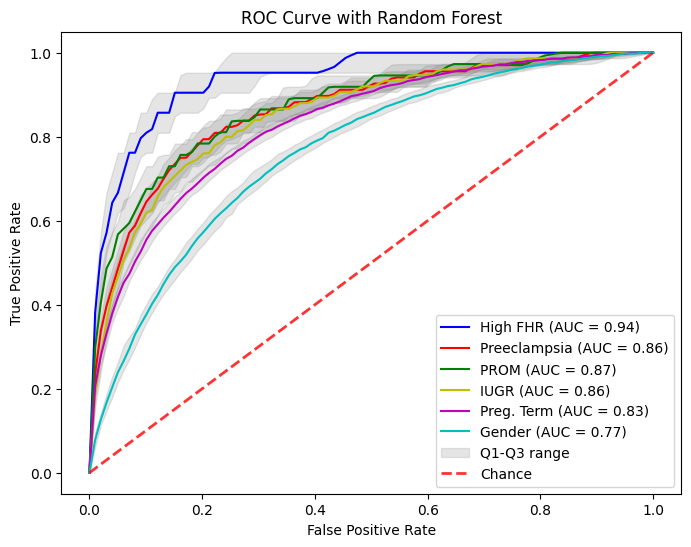

In [ ]:
median_tpr_1=np.median(result_list[0]["tprs"],axis=0)
q1_tpr_1=np.quantile(result_list[0]["tprs"],0.25,axis=0)
q3_tpr_1=np.quantile(result_list[0]["tprs"],0.75,axis=0)
median_tpr_2=np.median(result_list[1]["tprs"],axis=0)
q1_tpr_2=np.quantile(result_list[1]["tprs"],0.25,axis=0)
q3_tpr_2=np.quantile(result_list[1]["tprs"],0.75,axis=0)
median_tpr_3=np.median(result_list[2]["tprs"],axis=0)
q1_tpr_3=np.quantile(result_list[2]["tprs"],0.25,axis=0)
q3_tpr_3=np.quantile(result_list[2]["tprs"],0.75,axis=0)
median_tpr_4=np.median(result_list[3]["tprs"],axis=0)
q1_tpr_4=np.quantile(result_list[3]["tprs"],0.25,axis=0)
q3_tpr_4=np.quantile(result_list[3]["tprs"],0.75,axis=0)
median_tpr_5=np.median(result_list[4]["tprs"],axis=0)
q1_tpr_5=np.quantile(result_list[4]["tprs"],0.25,axis=0)
q3_tpr_5=np.quantile(result_list[4]["tprs"],0.75,axis=0)
median_tpr_6=np.median(result_list[5]["tprs"],axis=0)
q1_tpr_6=np.quantile(result_list[5]["tprs"],0.25,axis=0)
q3_tpr_6=np.quantile(result_list[5]["tprs"],0.75,axis=0)

plt.figure(figsize=(8,6))
plt.plot(result_list[0]["mean_fpr"],median_tpr_1,color='b',label='High FHR (AUC = %0.2f)' % np.median(np.median(result_list[0]["aucs"])))
plt.plot(result_list[1]["mean_fpr"],median_tpr_2,color='r',label="Preeclampsia (AUC = %0.2f)" % np.median(np.median(result_list[1]["aucs"])))
plt.plot(result_list[2]["mean_fpr"],median_tpr_3,color='g',label="PROM (AUC = %0.2f)" % np.median(np.median(result_list[2]["aucs"])))
plt.plot(result_list[3]["mean_fpr"],median_tpr_4,color='y',label="IUGR (AUC = %0.2f)" % np.median(np.median(result_list[3]["aucs"])))
plt.plot(result_list[4]["mean_fpr"],median_tpr_5,color='m',label="Preg. Term (AUC = %0.2f)" % np.median(np.median(result_list[4]["aucs"])))
plt.plot(result_list[5]["mean_fpr"],median_tpr_6,color='c',label="Gender (AUC = %0.2f)" % np.median(np.median(result_list[5]["aucs"])))
plt.fill_between(result_list[0]["mean_fpr"],q1_tpr_1,q3_tpr_1,color='grey',alpha=0.2,label="Q1-Q3 range")
plt.fill_between(result_list[1]["mean_fpr"],q1_tpr_2,q3_tpr_2,color='grey',alpha=0.2)
plt.fill_between(result_list[2]["mean_fpr"],q1_tpr_3,q3_tpr_3,color='grey',alpha=0.2)
plt.fill_between(result_list[3]["mean_fpr"],q1_tpr_4,q3_tpr_4,color='grey',alpha=0.2)
plt.fill_between(result_list[4]["mean_fpr"],q1_tpr_5,q3_tpr_5,color='grey',alpha=0.2)
plt.fill_between(result_list[5]["mean_fpr"],q1_tpr_6,q3_tpr_6,color='grey',alpha=0.2)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Random Forest')
plt.legend(loc="lower right")
plt.show()


You can also print out the calculated median metrics.

In [ ]:
medians1=result_list[0]["medians"]
print(f"median balanced accuracy for high FHR: {medians1["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for high FHR: {medians1["median_metrics"]["sensitivity"]}")
print(f"median specificity for high FHR: {medians1["median_metrics"]["specificity"]}")
print(f"median precision for high FHR: {medians1["median_metrics"]["precision"]}")
medians2=result_list[1]["medians"]
print(f"median balanced accuracy for preeclampsia: {medians2["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for preeclampsia: {medians2["median_metrics"]["sensitivity"]}")
print(f"median specificity for preeclampsia: {medians2["median_metrics"]["specificity"]}")
print(f"median precision for preeclampsia: {medians2["median_metrics"]["precision"]}")
medians3=result_list[2]["medians"]
print(f"median balanced accuracy for PROM: {medians3["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for PROM: {medians3["median_metrics"]["sensitivity"]}")
print(f"median specificity for PROM: {medians3["median_metrics"]["specificity"]}")
print(f"median precision for PROM: {medians3["median_metrics"]["precision"]}")
medians4=result_list[3]["medians"]
print(f"median balanced accuracy for IUGR: {medians4["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for IUGR: {medians4["median_metrics"]["sensitivity"]}")
print(f"median specificity for IUGR: {medians4["median_metrics"]["specificity"]}")
print(f"median precision for IUGR: {medians4["median_metrics"]["precision"]}")
medians5=result_list[4]["medians"]
print(f"median balanced accuracy for preg. term: {medians5["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for preg. term: {medians5["median_metrics"]["sensitivity"]}")
print(f"median specificity for preg. term: {medians5["median_metrics"]["specificity"]}")
print(f"median precision for preg. term: {medians5["median_metrics"]["precision"]}")
medians6=result_list[5]["medians"]
print(f"median balanced accuracy for gender: {medians6["median_metrics"]["balanced_accuracy"]}")
print(f"median sensitivity for gender: {medians6["median_metrics"]["sensitivity"]}")
print(f"median specificity for gender: {medians6["median_metrics"]["specificity"]}")
print(f"median precision for gender: {medians6["median_metrics"]["precision"]}")

median balanced accuracy for high FHR: 0.6519035054655107
median sensitivity for high FHR: 0.30952380952380953
median specificity for high FHR: 0.9938434476693052
median precision for high FHR: 0.5
median balanced accuracy for preeclampsia: 0.6895979492714517
median sensitivity for preeclampsia: 0.4117647058823529
median specificity for preeclampsia: 0.963302752293578
median precision for preeclampsia: 0.4161255411255411
median balanced accuracy for PROM: 0.6563637678713503
median sensitivity for PROM: 0.32432432432432434
median specificity for PROM: 0.9875111507582516
median precision for PROM: 0.45161290322580644
median balanced accuracy for IUGR: 0.6785318559556787
median sensitivity for IUGR: 0.38666666666666666
median specificity for IUGR: 0.9649122807017544
median precision for IUGR: 0.43057448880233695
median balanced accuracy for preg. term: 0.7440289219463048
median sensitivity for preg. term: 0.6434540389972145
median specificity for preg. term: 0.8454317897371715
median prec

You can also plot permutation importances for the estimators. Make sure to use them in the same way it was used in the training and evaluating. Fit with the bootstrapped and if SMOTE was needed the resampled datasets.

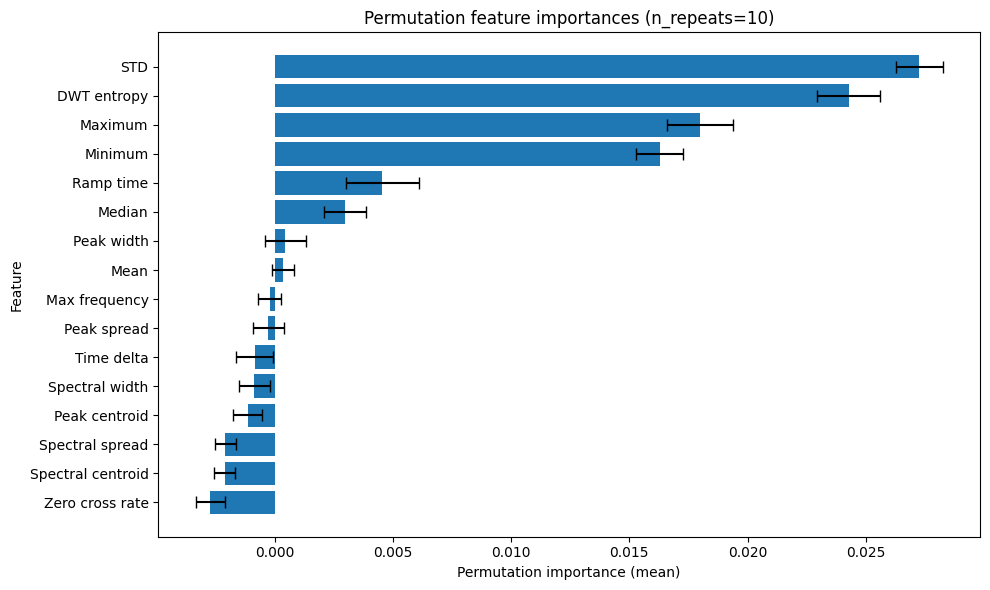

In [21]:
X_train,X_test,Y_train,Y_test=train_test_split(Xs[3],Ys[3],test_size=0.2,random_state=42)
X_train_bootstrap,Y_train_bootstrap=resample(X_train,Y_train,replace=True,n_samples=len(X_train),random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train_bootstrap, Y_train_bootstrap)
models["rf"]["estimator"].fit(X_train_resampled,Y_train_resampled)
df_importances=fPCG_pipeline.plot_perm_importance(models["rf"]["estimator"],
                                                  X_train,Y_train)